Libraries imported successfully
Shape: (1158, 13)
Selected features: ['ppg_rms', 'ppg_std', 'red_ac', 'peak_count', 'ir_ac']
Features shape: (1158, 5)
Targets shape: (1158, 2)
X_train: (578, 5) X_test: (580, 5)
y_train: (578, 2) y_test: (580, 2)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                384       
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
      

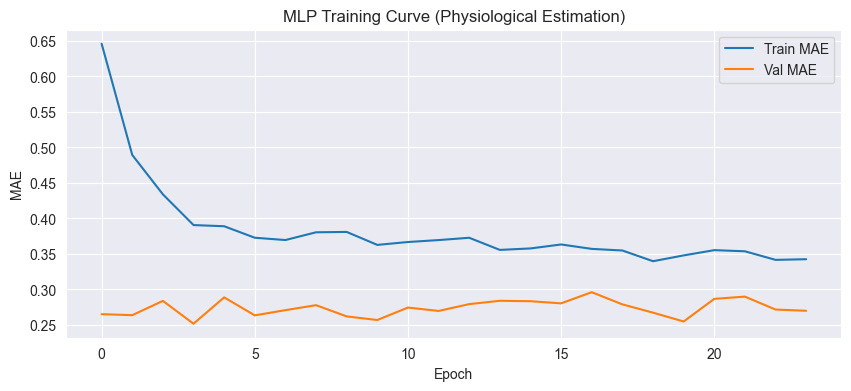

19/19 [==============================] - 0s 1ms/step
Test MAE (HR): 5.04 bpm
Test MAE (SpO₂): 0.4940 R_ratio units


C:\Users\n\AppData\Local\Temp\ipykernel_24384\413493556.py:119: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\n\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


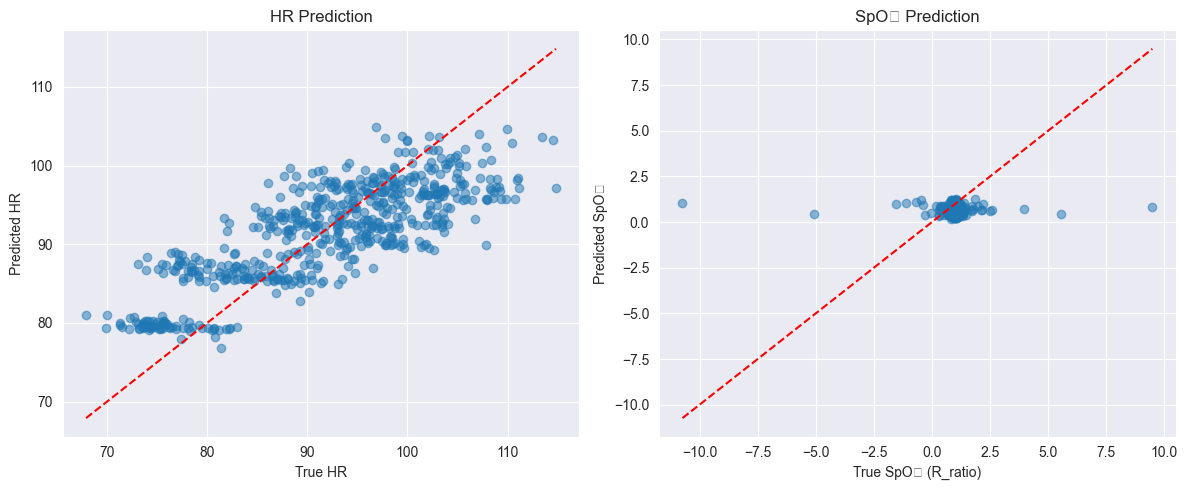

INFO:tensorflow:Assets written to: Deep Learning Module/models/physio_mlp_tf\assets


INFO:tensorflow:Assets written to: Deep Learning Module/models/physio_mlp_tf\assets


TensorFlow MLP model and scalers saved successfully!


In [6]:
#========================================================
# Physiological Parameter Prediction (TensorFlow MLP)
#========================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

print("Libraries imported successfully")

DATA_PATH = "../Data/processed/ppg_features.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

selected_ppg_features = ['ppg_rms', 'ppg_std', 'red_ac', 'peak_count', 'ir_ac']
X = df[selected_ppg_features]
y = df[['hr_bpm', 'R_ratio']]

print("Selected features:", selected_ppg_features)
print("Features shape:", X.shape)
print("Targets shape:", y.shape)

subjects = df['subject_id'].unique()
split_idx = int(0.7 * len(subjects))
train_subjects = subjects[:split_idx]
test_subjects = subjects[split_idx:]

train_idx = df['subject_id'].isin(train_subjects)
test_idx = df['subject_id'].isin(test_subjects)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(2, activation='linear')  # output: HR and R_ratio
])

model.compile(optimizer=Adam(0.001),
              loss='mse',
              metrics=['mae'])

model.summary()

early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=True
)

plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MLP Training Curve (Physiological Estimation)')
plt.legend()
plt.show()

y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

from sklearn.metrics import mean_absolute_error

mae_hr = mean_absolute_error(y_test['hr_bpm'], y_pred[:, 0])
mae_spo2 = mean_absolute_error(y_test['R_ratio'], y_pred[:, 1])
print(f"Test MAE (HR): {mae_hr:.2f} bpm")
print(f"Test MAE (SpO₂): {mae_spo2:.4f} R_ratio units")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test['hr_bpm'], y_pred[:, 0], alpha=0.5)
plt.plot([y_test['hr_bpm'].min(), y_test['hr_bpm'].max()],
         [y_test['hr_bpm'].min(), y_test['hr_bpm'].max()], 'r--')
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("HR Prediction")

plt.subplot(1, 2, 2)
plt.scatter(y_test['R_ratio'], y_pred[:, 1], alpha=0.5)
plt.plot([y_test['R_ratio'].min(), y_test['R_ratio'].max()],
         [y_test['R_ratio'].min(), y_test['R_ratio'].max()], 'r--')
plt.xlabel("True SpO₂ (R_ratio)")
plt.ylabel("Predicted SpO₂")
plt.title("SpO₂ Prediction")

plt.tight_layout()
plt.show()

os.makedirs("Deep Learning Module/models", exist_ok=True)
model.save("Deep Learning Module/models/physio_mlp_tf")
joblib.dump(scaler_X, "Deep Learning Module/models/physio_scaler_X_tf.pkl")
joblib.dump(scaler_y, "Deep Learning Module/models/physio_scaler_y_tf.pkl")

print("TensorFlow MLP model and scalers saved successfully!")
